In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import *
import tensorflow as tf

import os
import time

Load Data

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
path = '/content/gdrive/My Drive/Plastic_Recyclability_Dataset'

batches = []
for batch in os.listdir(path):
    if batch[0:5] == "batch":
        batches.append(np.fromfile(path + "/" + batch, dtype=np.uint8, count=-1))
inputs = np.concatenate(batches)

labels = np.fromfile(path + "/labels.bin", dtype=np.uint8, count=-1)

inputs = inputs.reshape((-1,128,128,3))
print(inputs.shape)

print(labels.shape)

(8424, 128, 128, 3)
(8424,)


In [0]:
# batches = []
# for batch in os.listdir("data/batches"):
#     if batch[0:5] == "batch":
#         batches.append(np.fromfile("data/batches/" + batch, dtype=np.uint8, count=-1))
# inputs = np.concatenate(batches)

# labels = np.fromfile("data/batches/labels.bin", dtype=np.uint8, count=-1)

# inputs = inputs.reshape((-1,128,128,3))
# print(inputs.shape)

# print(labels.shape)

In [3]:
print("number of recyclable items:", len(labels[labels[0]==0]))
print("number of maybe recyclable items:", len(labels[labels[0]==1]))

number of recyclable items: 0
number of maybe recyclable items: 1


In [91]:
test_size = 0.15
val_size = 0.1

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(inputs, labels,
                                                                              test_size = test_size, random_state = 0)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val,
                                                                        test_size = val_size / (1 - test_size), 
                                                                        random_state = 0)

print("X train:", X_train.shape)
print("Y train:", y_train.shape)
print("X validation:", X_val.shape)
print("Y validation:", y_val.shape)
print("X test:", X_test.shape)
print("Y test:", y_test.shape)

X train: (6317, 128, 128, 3)
Y train: (6317,)
X validation: (843, 128, 128, 3)
Y validation: (843,)
X test: (1264, 128, 128, 3)
Y test: (1264,)


In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=180,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(X_train)

recyclable


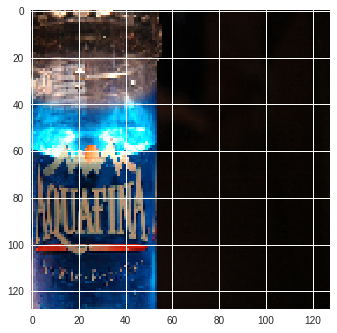

In [71]:
num = 1530
plt.imshow(inputs[num])
if labels[num] == 0:
    print("recyclable")
elif labels[num] == 1:
    print("non-recyclable")
else:
    print("label not 0 or 1")

In [0]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=[2,2]))


model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=[2,2]))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2), activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=[2,2]))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1000, activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(units=500, activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(units=2, activation=tf.nn.softmax))

model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.000001),
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])

In [0]:
start = time.time()
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))
end = time.time()
print(end-start, "seconds elapsed")

In [0]:
def create_convblock(input_tensor, filters, kernel_size=(2,2), strides=(1,1), name="", padding="valid", activation=True):
  x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, data_format="channels_last",
                             use_bias=False, name="conv"+name, kernel_initializer="he_normal", 
                             kernel_regularizer=tf.keras.regularizers.l2(1e-2))(input_tensor)
  
 # x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=(1,1), padding=padding, data_format="channels_last",
  #                           use_bias=False, name="conv"+name, kernel_initializer="he_normal", 
  #                           kernel_regularizer=tf.keras.regularizers.l2(1e-2))(input_tensor)
  #x = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=strides, padding="same")(x)
  
  x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-4, trainable=True, name="batch_norm"+name)(x)
  if(activation):
    x = tf.keras.layers.ReLU(name="relu"+name)(x)
  return x

In [0]:
def create_resblock(input_tensor, filters, kernel_size=(2,2), strides=(1,1), padding="same", block_num=0):
  s = str(block_num)
  sa = s + "a"
  sb = s + "b"
  
  x = create_convblock(input_tensor, filters, kernel_size=kernel_size, strides=strides, padding=padding, name=s+"a")
  
  x = create_convblock(x, filters, kernel_size=kernel_size, strides=strides, padding=padding, name=s+"b", activation=False)

  x = tf.keras.layers.add([input_tensor, x], name="add"+s)
  x = tf.keras.layers.ReLU(name="relu"+s+"b")(x)
  x = tf.keras.layers.SpatialDropout2D(rate=0.2)(x)
  return x

In [0]:
def create_downsample_resblock(input_tensor, filters, kernel_size=(3,3), padding="same", block_num=0):
  s = str(block_num)
  
  x = create_convblock(input_tensor, filters, kernel_size=kernel_size, strides=(2,2), padding=padding, name=s+"a")
  
  x = create_convblock(x, filters, kernel_size=kernel_size, strides=(1,1), padding=padding, name=s+"b", activation=False)
  
  #1x1 convolutions with stride 2 on input tensor
  input_tensor = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=(2,2), padding=padding, name="conv_1x1"+s)(input_tensor)
  
  x = tf.keras.layers.add([input_tensor, x], name="add"+s)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.SpatialDropout2D(rate=0.2)(x)
  return x

In [0]:
filters=16

input_tensor = tf.keras.layers.Input(shape=(128,128,3))
x = create_convblock(input_tensor, filters, kernel_size=(3,3), strides=(2,2), name="0") 

x = create_resblock(x, filters, kernel_size=(3,3), block_num=1)
x = create_resblock(x, filters, kernel_size=(3,3), block_num=2)
x = create_resblock(x, filters, kernel_size=(3,3), block_num=3)

filters=32
x = create_downsample_resblock(x, filters, kernel_size=(3,3), block_num=4)
x = create_resblock(x, filters, kernel_size=(3,3), block_num=5)
x = create_resblock(x, filters, kernel_size=(3,3), block_num=6)

filters=64
x = create_downsample_resblock(x, filters, kernel_size=(3,3), block_num=7)
x = create_resblock(x, filters, kernel_size=(3,3), block_num=8)
x = create_resblock(x, filters, kernel_size=(3,3), block_num=9)

filters=128
x = create_downsample_resblock(x, filters, kernel_size=(2,2), block_num=10)
x = create_resblock(x, filters, kernel_size=(2,2), block_num=11)
x = create_resblock(x, filters, kernel_size=(2,2), block_num=12)

#filters=256
#x = create_downsample_resblock(x, filters, kernel_size=(2,2), block_num=13)
#x = create_resblock(x, filters, kernel_size=(2,2), block_num=14)
#x = create_resblock(x, filters, kernel_size=(2,2), block_num=15)


#x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = tf.keras.layers.Dense(units=2, kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                         bias_regularizer=tf.keras.regularizers.l2(1e-4))(x)
#x = tf.keras.backend.cast(x, 'float32')
output = tf.keras.layers.Softmax()(x)
#output = tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)(x)

model = tf.keras.Model(inputs=input_tensor, outputs=output)
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, epsilon=1e-3),
#model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9, decay=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
  
  

In [149]:
batch_size=128
start = time.time()
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val))
#model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size, epochs=10, validation_data=(X_val, y_val))
end = time.time()
print(end-start, "seconds elapsed")

Train on 6317 samples, validate on 843 samples
Epoch 1/50
6317/6317 [==============================] - 35s 5ms/sample - loss: 56.1751 - acc: 0.5064 - val_loss: 49.5106 - val_acc: 0.5184
Epoch 2/50
6317/6317 [==============================] - 19s 3ms/sample - loss: 43.0540 - acc: 0.5235 - val_loss: 36.1263 - val_acc: 0.4947
Epoch 3/50
6317/6317 [==============================] - 19s 3ms/sample - loss: 30.4805 - acc: 0.5376 - val_loss: 24.8962 - val_acc: 0.4840
Epoch 4/50
6317/6317 [==============================] - 19s 3ms/sample - loss: 20.5917 - acc: 0.5645 - val_loss: 16.5313 - val_acc: 0.5136
Epoch 5/50
6317/6317 [==============================] - 18s 3ms/sample - loss: 13.5115 - acc: 0.5746 - val_loss: 10.7630 - val_acc: 0.5231
Epoch 6/50
1664/6317 [======>.......................] - ETA: 13s - loss: 10.1952 - acc: 0.5643

KeyboardInterrupt: ignored

In [51]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 63, 63, 16)   432         input_14[0][0]                   
__________________________________________________________________________________________________
batch_norm0 (BatchNormalization (None, 63, 63, 16)   64          conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (ReLU)                    (None, 63, 63, 16)   0           batch_norm0[0][0]                
__________________________________________________________________________________________________
conv1a (Co

In [52]:
tf.trainable_variables(scope=None)

[<tf.Variable 'conv0/kernel:0' shape=(3, 3, 3, 16) dtype=float32>,
 <tf.Variable 'batch_norm0/gamma:0' shape=(16,) dtype=float32>,
 <tf.Variable 'batch_norm0/beta:0' shape=(16,) dtype=float32>,
 <tf.Variable 'conv1a/kernel:0' shape=(3, 3, 16, 16) dtype=float32>,
 <tf.Variable 'batch_norm1a/gamma:0' shape=(16,) dtype=float32>,
 <tf.Variable 'batch_norm1a/beta:0' shape=(16,) dtype=float32>,
 <tf.Variable 'conv1b/kernel:0' shape=(3, 3, 16, 16) dtype=float32>,
 <tf.Variable 'batch_norm1b/gamma:0' shape=(16,) dtype=float32>,
 <tf.Variable 'batch_norm1b/beta:0' shape=(16,) dtype=float32>,
 <tf.Variable 'conv2a/kernel:0' shape=(3, 3, 16, 16) dtype=float32>,
 <tf.Variable 'batch_norm2a/gamma:0' shape=(16,) dtype=float32>,
 <tf.Variable 'batch_norm2a/beta:0' shape=(16,) dtype=float32>,
 <tf.Variable 'conv2b/kernel:0' shape=(3, 3, 16, 16) dtype=float32>,
 <tf.Variable 'batch_norm2b/gamma:0' shape=(16,) dtype=float32>,
 <tf.Variable 'batch_norm2b/beta:0' shape=(16,) dtype=float32>,
 <tf.Variable 

In [0]:
#save weights
model.save_weights(path + "/checkpoints/cp.cpkt", save_format='tf')

In [0]:
p_train = model.predict(X_train)
p_train = np.argmax(p_train, axis=1)

p_val = model.predict(X_val)
p_val = np.argmax(p_val, axis=1)

print("train acc:", metrics.accuracy_score(y_train, p_train))
print("validation acc:", metrics.accuracy_score(y_val, p_val))

In [0]:
p_test = model.predict(X_test)
p_test = np.argmax(p_test, axis=1)

print("test acc:", metrics.accuracy_score(y_test, p_test))

In [0]:
p_test = model.predict(inputs)
p_test = np.argmax(p_test, axis=1)

print("test acc:", metrics.accuracy_score(labels, p_test))